# EVOLUTIONARY CITY MODEL
## An Agent Based Model
*Put this notebook in the same folder where the virtualenv is created to avoid dependency conflicts.*

### Model Description 

* The model uses a payoff function of the form $U = rn + kS - cn^2$ 
    - $r$ is the ability of an agent, drawn from a uniform distribution(0,1). Depending on the value each agent is labelled type $H$(high skilled) for $r>0.5$ or $L$ (low skilled) otherwise. 
    - $S$ is the no. of a particular agent-type in the neighboring cell 
    - $n$ is no of agents in the neighboring cell.  
    
* In the current form U consists of the positive terms which we thought as benefits from moving to cells with similar agents (term $kS$) such as knowledge spillovers and the benefits he gets from a cell population depending on his skill level (term $rn$) such as high income. The negative term accounts for disadvantages from a dense population (term $cn^2$) such as higher living costs, pollution etc.

* Agents have only one attribute , the skill level $r$. Accordingly, they are shown as red for 'L' and blue for 'H' in the grid visualization.

* The model takes the total number of agents $N$, the positive coefficient $k$ and negative coefficient $c$ as inputs. The model also takes agent activation schedule as input to test two schedules. Pass "activation=0" for RandomActivation and "activation=1" for SimultaneousActivation.

* Since the datacollector is not implemented analysis is not done yet.

* The final cell launches a server to visualize the model and tweak the above parameters. However, to change the code and launch the server again I had to specify a different server.port or quit the notebook and launch again from command prompt. This might be a problem specific to my environment setup but might help somebody. 

In [3]:
from mesa import Agent, Model
from mesa.time import RandomActivation, SimultaneousActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from math import ceil
import pandas as pd
import random
import numpy as np

from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import CanvasGrid, ChartModule, TextElement
from mesa.visualization.UserParam import UserSettableParameter
import matplotlib.pyplot as plt
from matplotlib import animation

In [4]:
def city_sizes(model):
    agent_counts = np.zeros((model.grid.width, model.grid.height))
    for cell in model.grid.coord_iter():
        cell_content, x, y = cell
        agent_count = len(cell_content)
        agent_counts[x][y] = agent_count
    return agent_counts

class habitant(Agent):
    
    def __init__(self, unique_id, model, agent_ability, pos):
        super().__init__(unique_id, model)
        self.r = agent_ability
        self.radius = ceil(np.random.beta(1,1) * 20)
        self.pos = pos
        self.type = None
        if 0 <= 10*self.r < 6:
            self.type = 'L'
        elif 6 <= 10*self.r <=10:
            self.type = 'H' 
            
        self.steps = 0
        
    def utility(self, coord):
        neighbor_agents = self.model.grid.get_cell_list_contents([coord])
        agent_types = [agent.type for agent in neighbor_agents]
        n = len(neighbor_agents)
        S = 0
        if self.type == 'L':
            S = agent_types.count('L')
        else:
            S = agent_types.count('H')

        return self.r * n + self.model.k * S - self.model.c * n**2                        # Utility = rn + kS - cn^2  
    
    def move(self):
        neighbor_cells = self.model.grid.get_neighborhood(self.pos,moore=True,include_center=False,radius=self.radius)
        utility_list = []
        for n in neighbor_cells:
            utility_list.append([n, self.utility(n)])

        util =[]
        max_pos = None
        for i in utility_list:
            util.append(i[1])
            if i[1] == max(util):
                max_pos = i[0]   
            
        agents_max_pos = self.model.grid.get_cell_list_contents(max_pos)
        self.model.grid.move_agent(self, max_pos)
                
    def step(self):
        #for RandomActivation
        if self.model.act == 0:
            self.move()
        elif self.model.act == 1:
            self.steps += 1
    
    #for SimultaneousActivation
    def advance(self):    
        self.move()
        

class city_model(Model):
    """A model with some number of agents"""
    def __init__(self, height=20, width=20, N=1000, neg_coff= 0.2, pos_coff = 1, activation = 0):
        assert activation in [0,1], 'Activation should be in "[0, 1]". O for RANDOM , 1 for Simultaneous'
        self.height = height
        self.width = width
        self.num_agents = N
        self.c = neg_coff
        self.k = pos_coff
        self.act = activation
        if self.act == 0:
            self.schedule = RandomActivation(self)
        elif self.act == 1:
            self.schedule = SimultaneousActivation(self) 
        
        self.grid = MultiGrid(width,height,True)
        self.running = True
       
        #Create agents with some ability
        for i in range(self.num_agents):
            agent_ability = np.random.uniform()
                
            # Add the agent to random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            agent = habitant(i, self, agent_ability, (x,y))
            self.schedule.add(agent)
            self.grid.place_agent(agent, (x,y))
            
        self.datacollector = DataCollector(model_reporters={"City_sizes": city_sizes})

            
    def step(self):
        """Advance the model by one step"""
        self.datacollector.collect(self)
        self.schedule.step()    

In [ ]:
def city_draw(agent):
    """
    Portrayal Method for canvas
    """
    if agent is None:
        return
    portrayal = {"Shape": "circle", "r": 0.5, "Filled": "true", "Layer": 0}

    if agent.type == 'L':
        portrayal["Color"] = ["#FF0000", "#FF9999"]
        portrayal["stroke_color"] = "#00FF00"
    else:
        portrayal["Color"] = ["#0000FF", "#9999FF"]
        portrayal["stroke_color"] = "#000000"
    return portrayal

canvas_element = CanvasGrid(city_draw, 20, 20, 500, 500)
model_params = {
    "height": 20,
    "width": 20,
    "N": UserSettableParameter("slider", "Number of Agents", 1000, 500, 2500, 500),
    "neg_coff": UserSettableParameter("slider", "Negative coefficient(c)", 0.2, 0.0, 1, 0.1),
    "pos_coff": UserSettableParameter("slider", "Positive Coefficeint(k)", 1, 0.5, 2, 0.25),
    "activation": UserSettableParameter("slider", "0 for Random, 1 for Simulatneous", 0, 0, 1, 1)
}

server = ModularServer(city_model, [canvas_element], "City Model", model_params)
server.launch()

In [5]:
# Run model without server
model = city_model(N=1000)

for i in range(50):
    model.step()

city_evolution = model.datacollector.get_model_vars_dataframe()

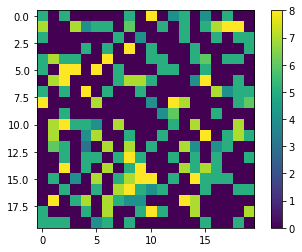

In [6]:
import time
from IPython.display import clear_output

## Plot city sizes over time. Colorbar should have fixed values to make it more clear.

plt.figure()
for i in range(50):
    plt.imshow(city_evolution["City_sizes"][i])
    plt.colorbar()
    plt.show()
    time.sleep(0.1)
    clear_output(wait=True)
    